# Candidates Generation

In [2]:
import pandas as pd
import os, sys
import numpy as np
import seaborn as sns
import gc
import warnings

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from gensim.models import Word2Vec

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, SpatialDropout1D, \
                          UpSampling1D, LSTM, RepeatVector, TimeDistributed, GRU, Bidirectional, concatenate, \
                          Reshape, Dropout, BatchNormalization, GlobalAveragePooling1D, GlobalAveragePooling2D

from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from custom_functions import norm_text, norm_brands, norm_images

pd.set_option('max_colwidth', 250)
warnings.filterwarnings(action='once')

Using TensorFlow backend.


In [13]:
path = os.path.join('../Data/')
path_models = os.path.join('../Models/')

In [14]:
print (os.listdir(path_models))

['desktop.ini', 'encoder_text.h5', 'full_autoencoder.h5', 'full_encoder.h5', 'word2vec_model']


In [15]:
data = pd.read_csv(path + 'FinalItems/data_filtered.csv', sep = ';')
data_customers = pd.read_csv(path + 'customers_data.csv', sep = ';')
data_customers.shape

(348183, 6)

In [16]:
data.head()

,item_id,availability_date,brand,category,name,price
0,A28233506,NaN,Woman Limited El Corte Inglés,"['Moda', 'Mujer', 'Abrigos']",Abrigo masculino con textura de mujer,"{'final': 199, 'currency': 'EUR'}"
1,A29054782,NaN,Woman Limited El Corte Inglés,"['Moda', 'Mujer', 'Abrigos']",Abrigo doble faz de mujer con cinturón a tono,"{'final': 149, 'currency': 'EUR'}"
2,A27354432,NaN,Woman El Corte Inglés,"['Moda', 'Mujer', 'Abrigos']",Abrigo largo de antelina de mujer Woman El Corte Inglés,"{'final': 89.99, 'currency': 'EUR'}"
3,A28302706,NaN,Lloyd's,"['Moda', 'Mujer', 'Abrigos']",Chaqueta térmica de mujer Lloyds con efecto cortavientos,"{'final': 129, 'currency': 'EUR'}"
4,A27435502,NaN,Lloyd's,"['Moda', 'Mujer', 'Abrigos']",Parka 100% algodón de mujer Lloyds con capucha,"{'final': 149, 'currency': 'EUR'}"


In [17]:
data_customers.head()

,date,item_id,brand,PRICE,customer_id,text
0,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
1,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
2,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
3,20190101,A26036172,Tintoretto,"27,99",0,Vestido de mujer Tintoretto de flores con lazada
4,20190101,A26870590,Fórmula Joven,"19,99",0,Vestido laminado de mujer Fórmula Joven con escote en pico


In [19]:
%%time
#1min
brands = norm_brands.launch_normalizer(data_customers)
STOPWORDS_ALL =  norm_text.gen_stopwords(path)
lemmatizer_inv = norm_text.get_lemmatizer(path)
words = [word.split() for word in data_customers['text'].values]
for i in range(len(words)):
    data_customers['text'].values[i] = norm_text.normalize(words = words[i], p_brands = brands, 
                                                    STOPWORDS_ALL = STOPWORDS_ALL, 
                                                    lemmatizer_inv = lemmatizer_inv)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\enric\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
C:\Users\enric\Google Drive\PROYECTOS\TFM_Motor de Recomendacion\Master\99_FinalModel\Scripts\custom_functions\norm_text.py:18: ResourceWarning: unclosed file <_io.TextIOWrapper name='../Data/\\stopwords_catalan.txt' mode='r' encoding='UTF-8'>
  STOPWORDS_CAT = open(path + '\stopwords_catalan.txt', 'r', encoding= 'UTF-8').read().split()


Wall time: 4min 57s


In [20]:
data_customers.head()

,date,item_id,brand,PRICE,customer_id,text
0,20190101,A26036172,tintoretto,"27,99",0,vestido mujer flor lazada
1,20190101,A26036172,tintoretto,"27,99",0,vestido mujer flor lazada
2,20190101,A26036172,tintoretto,"27,99",0,vestido mujer flor lazada
3,20190101,A26036172,tintoretto,"27,99",0,vestido mujer flor lazada
4,20190101,A26870590,fórmula joven,"19,99",0,vestido laminado mujer formula joven escote pico


We clean some columns in the format we want

In [25]:
data_customers.columns = data_customers.columns.str.strip()
data_customers.PRICE = data_customers.PRICE.astype(float)
data_customers.PRICE = pd.to_numeric(data_customers['PRICE'])
data_customers.item_id = data_customers.item_id.apply(lambda x: x.strip())
data.item_id = data.item_id.apply(lambda x: x.strip())

In [27]:
data.columns = data.columns.str.strip()
data_customers['item_age'] = -1 * (data_customers['date'] - data['availability_date'])
data_customers['item_age'].fillna(0, inplace=True)

In [28]:
customers_unique = data_customers.customer_id.unique()
items_unique = data_customers.item_id.unique()
brand_unique = data_customers.brand.unique()

print (f'We have {len(customers_unique)} unique users and {len(items_unique)} unique items and {len(brand_unique)} unique brands')

We have 4453 unique users and 65984 unique items and 2559 unique brands


### We need integer data to be able to feed the NN

In [29]:
customers_map = {i:val for i,val in enumerate(customers_unique)}
customers_map_inv = {val:i for i,val in enumerate(customers_unique)}

items_map = {i:val for i,val in enumerate(items_unique)}
items_map_inv = {val:i for i,val in enumerate(items_unique)}

brands_map = {i:val for i,val in enumerate(brand_unique)}
brands_map_inv = {val:i for i,val in enumerate(brand_unique)}

In [30]:
data_customers['customer_id_int'] = data_customers['customer_id'].map(customers_map_inv)
data_customers['item_id_int'] = data_customers['item_id'].map(items_map_inv)
data_customers['brand_id'] = data_customers['brand'].map(brands_map_inv)
data_customers.shape

(348183, 10)

In [31]:
data_score = data_customers.groupby(['customer_id_int', 'item_id_int']).size().to_frame('score').reset_index().sort_values(by = 'score',ascending = False)

In [32]:
data_final = pd.merge(data_customers, data_score, how = 'inner')
data_final.shape

(348183, 11)

In [33]:
#remove duplicates due to agrupation, if a customer bought a item 2 times i only want 1 row with score 2, instead of 2 rows
data_final.drop_duplicates(inplace=True)
data_final.dropna(how = 'any', inplace = True)

print(data_final.shape)
data_final.head()

(186397, 11)


,date,item_id,brand,PRICE,customer_id,text,item_age,customer_id_int,item_id_int,brand_id,score
0,20190101,A26036172,tintoretto,27.99,0,vestido mujer flor lazada,0.0,0,0,0,13
4,20190115,A26036172,tintoretto,27.99,0,vestido mujer flor lazada,0.0,0,0,0,13
8,20190220,A26036172,tintoretto,27.99,0,vestido mujer flor lazada,0.0,0,0,0,13
12,20190304,A26036172,tintoretto,27.99,0,vestido mujer flor lazada,0.0,0,0,0,13
13,20190101,A26870590,fórmula joven,19.99,0,vestido laminado mujer formula joven escote pico,0.0,0,1,1,4


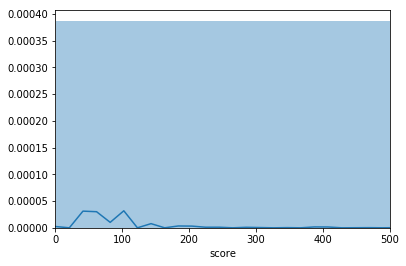

In [34]:
sns.distplot(data_score['score'], bins = 1).set(xlim = (0, 500)); #Popularity distribution

## Vectorize sentences

In [35]:
MAX_NB_WORDS = 30_000 #decided by cumsum wordcount plot (Script 01)
MAX_SEQUENCE_LENGTH = 24 #decided by max words in a product (Script 00)
EMBEDDING_DIM = 100 #Same dim as our W2V embedding

all_text = data_final['text']
all_text = all_text.drop_duplicates (keep = False)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, )
tokenizer.fit_on_texts(all_text)

data_sequences = tokenizer.texts_to_sequences(data_final['text'])
data_vec = pad_sequences(data_sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15982 unique tokens.


In [36]:
len(data_vec)

186397

In [37]:
data_final.shape

(186397, 11)

In [39]:
modelWV = Word2Vec.load(path_models + 'word2vec_model')
#encoder = load_model('encoder_text_V2.h5')

In [40]:
word_vectors = modelWV.wv
vocabulary_size = len(word_index) + 1
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in modelWV:
        embedding_matrix[i] = modelWV[word]
    else:
        embedding_matrix[i] = np.random.rand(1, EMBEDDING_DIM)[0]
            

del(word_vectors)

embedding_layer = Embedding(input_dim = vocabulary_size,
                            output_dim = EMBEDDING_DIM,
                            input_length = MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            name='w2v_embedding',
                            trainable=False)

C:\Users\enric\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\enric\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


## Output

In [26]:
gc.enable()
del (data, data_score, data_customers, modelWV)
gc.collect()

68

In [41]:
CAT_ITEMS = len(items_unique)

In [42]:
items_encoded = to_categorical(data_final['item_id_int'], num_classes = CAT_ITEMS)
print(items_encoded)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [43]:
items_encoded.shape

(186397, 65984)

## Scale continuous data

In [44]:
scaler = MinMaxScaler(feature_range = (0, 1))
data_to_scale1 = np.array([[x] for x in data_final['PRICE']])
data_to_scale2 = np.array([[x] for x in data_final['score']])
data_to_scale3 = np.array([[x] for x in data_final['item_age']])
scaled_data1 = scaler.fit_transform(data_to_scale1)
scaled_data2 = scaler.fit_transform(data_to_scale2)
scaled_data3 = scaler.fit_transform(data_to_scale3)

C:\Users\enric\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [45]:
data_final['score_original'] = data_final['score']
data_final['PRICE'] = scaled_data1.reshape(data_to_scale1.shape[0])
data_final['score'] = scaled_data2.reshape(data_to_scale2.shape[0])
data_final['item_age'] = scaled_data3.reshape(data_to_scale3.shape[0])

data_final['power_price'] = np.power(scaled_data1.reshape(data_to_scale1.shape[0]), 2)
data_final['power_score'] = np.power(scaled_data2.reshape(data_to_scale2.shape[0]), 2)
data_final['power_item_age'] = np.power(scaled_data3.reshape(data_to_scale3.shape[0]), 2)

data_final['sqrt_price'] = np.sqrt(scaled_data1.reshape(data_to_scale1.shape[0]))
data_final['sqrt_score'] = np.sqrt(scaled_data2.reshape(data_to_scale2.shape[0]))
data_final['sqrt_item_age'] = np.sqrt(scaled_data3.reshape(data_to_scale3.shape[0]))


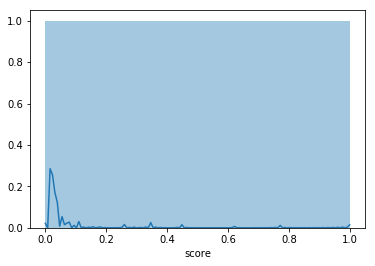

In [47]:
sns.distplot(data_final['score'], bins = 1); #Popularity item distribution

In [48]:
data_final.to_csv(path + 'FinalItems/data_final.csv', index=False)

## Architecture

In [49]:
data_final.head(3)
print(data_final.shape)

(186397, 18)


In [50]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
brand_id_input = Input(shape = [1], name = 'brand')

price_input = Input(shape = [1], name = 'price')
score_input = Input(shape = [1], name = 'score')
item_age_input = Input(shape = [1], name = 'item_age')

price_power_input = Input(shape = [1], name = 'power_price')
score_power_input = Input(shape = [1], name = 'power_score')
item_age_power_input = Input(shape = [1], name = 'power_item_age')

price_sqrt_input = Input(shape = [1], name = 'sqrt_price')
score_sqrt_input = Input(shape = [1], name = 'sqrt_score')
item_age_sqrt_input = Input(shape = [1], name = 'sqrt_item_age')

sequence_input = Input(shape = (MAX_SEQUENCE_LENGTH, ), name = 'text')

embedding_size = 20
item_embedding_size = 50

user_embedding = Embedding(output_dim=embedding_size, input_dim = customers_unique.shape[0]+1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=item_embedding_size, input_dim = items_unique.shape[0]+1,
                           input_length=1, name='item_embedding')(item_id_input)
brand_embedding = Embedding(output_dim=embedding_size, input_dim = brand_unique.shape[0]+1,
                           input_length=1, name='brand_embedding')(brand_id_input)

text_embedding = Embedding(*embedding_matrix.shape, weights = [embedding_matrix], trainable = False)(sequence_input)


user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([item_embedding_size])(item_embedding)
brand_vecs = Reshape([embedding_size])(brand_embedding)
text_flat = Flatten()(text_embedding)

x1 = concatenate([user_vecs, item_vecs, brand_vecs, price_input, item_age_input, score_input,
                 price_power_input, score_power_input, item_age_power_input,
                 price_sqrt_input, score_sqrt_input, item_age_sqrt_input, text_flat], name = 'VECTOR_PRODUCTO')

x2 = Dropout(0.4)(x1)
x3 = Dense (512, activation = 'relu')(x2)
x4 = Dropout(0.3)(x3)
x5 = Dense(256, activation = 'relu')(x4)
x6 = Dropout(0.2)(x5)
x7 = Dense(128, activation = 'relu')(x6)
x8 = Dropout(0.2)(x7)

output = Dense(CAT_ITEMS, activation = 'softmax' )(x8)

model = Model(inputs=[user_id_input, item_id_input, brand_id_input, price_input, sequence_input, item_age_input, score_input,
                     price_power_input, score_power_input, item_age_power_input,
                     price_sqrt_input, score_sqrt_input, item_age_sqrt_input], 
              outputs = output)

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['acc'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\enric\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
brand (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
text (InputLayer)               (None, 24)           0                                       

In [38]:
def plot_training(history):
    plt.plot(history.history['acc'])
    #plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [ ]:
history = model.fit([data_final['customer_id_int'], data_final['item_id_int'], 
                     data_final['brand_id'], data_final['PRICE'],
                     data_vec, data_final['item_age'], data_final['score'],
                     data_final['power_price'], data_final['power_score'], data_final['power_item_age'],
                     data_final['sqrt_price'], data_final['sqrt_score'], data_final['sqrt_item_age']],
                     items_encoded,
                     epochs = 30, #validation_split = 0.1,
                     batch_size = 256, verbose = 1,
                     shuffle = True)

#Epoch 5: loss = 7.6 & acc = 0.13
#Epoch 10: loss = 7.3 & acc = 0.16
#Epoch 20: loss = 6.97 & acc = 0.19
#Epoch 30: loss = 6.5 & acc = 0.229

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
186397/186397 [==============================] - 945s 5ms/sample - loss: 9.6000 - acc: 0.0442
Epoch 2/30
186397/186397 [==============================] - 1051s 6ms/sample - loss: 8.2517 - acc: 0.0883
Epoch 3/30
186397/186397 [==============================] - 1123s 6ms/sample - loss: 7.8695 - acc: 0.1108
Epoch 4/30
186397/186397 [==============================] - 1224s 7ms/sample - loss: 7.7043 - acc: 0.1256
Epoch 5/30
186397/186397 [==============================] - 1204s 6ms/sample - loss: 7.6330 - acc: 0.1340
Epoch 6/30
186397/186397 [==============================] - 1149s 6ms/sample - loss: 7.5592 - acc: 0.1405
Epoch 7/30
186397/186397 [==============================] - 944s 5ms/sample - loss: 7.4838 - acc: 0.1467
Epoch 8/30
186397/186397 [==============================] - 995s 5ms/sample - loss: 7.4739 - acc: 0.1520
Epoch 9/30
186397/186397 [==============================] - 5762s 31ms/sample - loss: 7.3972 - acc: 0.1556


In [51]:
#model.save(path_models + 'candidate_generation')
model = load_model(path_models + 'candidate_generation')

C:\Users\enric\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.


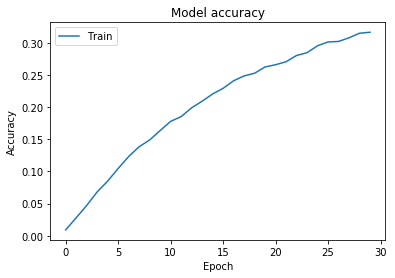

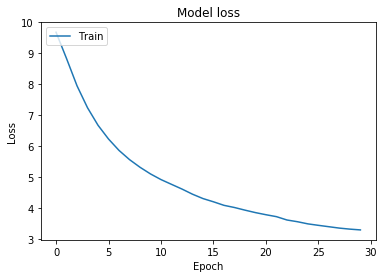

In [66]:
plot_training(history)

In [54]:
gc.enable()
del items_encoded
gc.collect()

883

---